# Setup

In [1]:
import contextily as cx
import xyzservices.providers as xyz
import figure_utilities
import statsmodels.api as sm
import constants
from stats_utilities import produce_summary_statistics, test_balance
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
import numpy as np
plt.rcParams['savefig.dpi'] = 300
import os
import pandas as pd

/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_23831/2481882148.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEO

In [2]:
# Set paths
INPUT_DATA_PANEL = "/Users/ashanmu1/Documents/GitHub/seniorthesis/data/03_cleaned/crime_analysis_monthly.csv"
INPUT_DATA_PANEL_FULL_SAMPLE = "/Users/ashanmu1/Documents/GitHub/seniorthesis/data/03_cleaned/crime_analysis_monthly_full_sample.csv"
INPUT_DATA_BOSTON_TRACTS_SHAPEFILE = "/Users/ashanmu1/Documents/GitHub/seniorthesis/data/01_raw/Census_2010_Tracts"
INPUT_DATA_TRACTS = "/Users/ashanmu1/Documents/GitHub/seniorthesis/data/02_intermediate/tracts.csv"
INPUT_DATA_OFFENSE_CODES = "/Users/ashanmu1/Documents/GitHub/seniorthesis/data/01_raw/rmsoffensecodes.xlsx"
INPUT_DATA_CRIME_COUNTS = "/Users/ashanmu1/Documents/GitHub/seniorthesis/data/03_cleaned/crime_counts.csv"
OUTPUT_TABLES = "/Users/ashanmu1/Documents/GitHub/seniorthesis/output/final_paper/tables"
OUTPUT_FIGURES = "/Users/ashanmu1/Documents/GitHub/seniorthesis/output/final_paper/figures"
OUTPUT_STATISTICS = "/Users/ashanmu1/Documents/GitHub/seniorthesis/output/final_paper/summary_statistics_numbers_to_cite.tex"

# Summary Statistics

## Map of Evictions, Colored by Poverty Rate in Census Tract

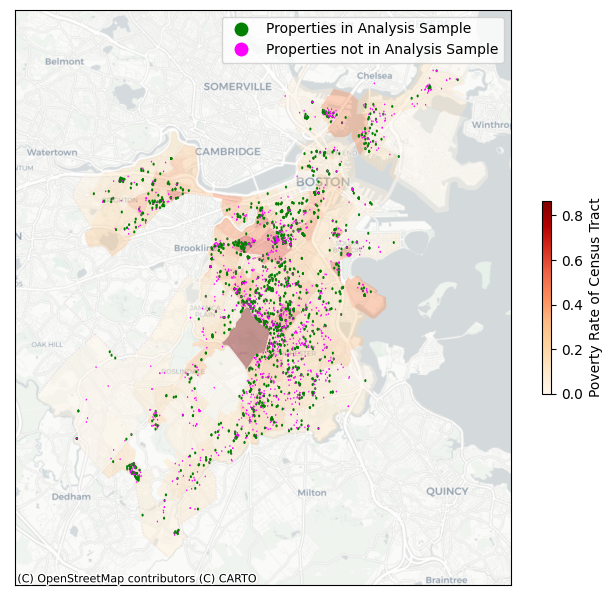

In [ ]:
# Read unrestricted dataset into memory.
df = pd.read_csv(INPUT_DATA_PANEL_FULL_SAMPLE, low_memory=False)
df = df.reset_index() # So we can use 'case_number' like a column

# Create spatial data 
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
df.loc[df['main_analysis_sample'] == 0, 'geometry'] = df.loc[df['main_analysis_sample'] == 0, 'geometry'].buffer(.0003)
df.loc[df['main_analysis_sample'] == 1, 'geometry'] = df.loc[df['main_analysis_sample'] == 1, 'geometry'].buffer(.0005)
df = df.set_crs("EPSG:4326")
df = df.to_crs("EPSG:3857")


# Plot
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])

# Color census tracts by poverty rate.
boston_tracts_gdf = gpd.read_file(INPUT_DATA_BOSTON_TRACTS_SHAPEFILE)[['GEOID10', 'geometry']].set_index('GEOID10')
boston_tracts_gdf.index = boston_tracts_gdf.index.astype(int)
tract_poverty_rates_df = pd.read_csv(INPUT_DATA_TRACTS, usecols=['tract_geoid', 'poor_share2010'],
                                     index_col='tract_geoid')
boston_tracts_gdf = pd.concat([boston_tracts_gdf, tract_poverty_rates_df], axis=1).dropna(
    subset=['geometry', 'poor_share2010']).drop(index=[25025990101, 25025980101])
boston_tracts_gdf.plot(ax=ax, column=boston_tracts_gdf['poor_share2010'], cmap='OrRd', alpha=0.4, legend=True,
                       legend_kwds={'label': "Poverty Rate of Census Tract",
                                    'shrink': 0.25})
boston_tracts_gdf = boston_tracts_gdf.reset_index()

df.loc[:, 'main_analysis_sample'] = df['main_analysis_sample'].replace({1: "Properties in Analysis Sample", 0: "Properties not in Analysis Sample"})
df.plot(ax=ax,
        column="main_analysis_sample",
        legend=True,
        cmap=colors.ListedColormap(['green', 'magenta']))

cx.add_basemap(ax=ax, crs="EPSG:3857", source='CartoDB.Positron')




figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

## Summary Statistics

In [4]:
# Read dataset into memory.
df = pd.read_csv(INPUT_DATA_PANEL, low_memory=False).reset_index()
sample_size = len(df)
df_full_sample = pd.read_csv(INPUT_DATA_PANEL_FULL_SAMPLE).reset_index()

outcomes_of_interest = [f'group_{i}_crimes_{constants.Analysis.MAIN_RESULTS_RADIUS}m' for i in range(3)]
summary_statistics_table = produce_summary_statistics(df)
all_excluded_properties_means = produce_summary_statistics(df_full_sample)

# Rename columns.
summary_statistics_table.index = summary_statistics_table.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.",'50%': 'Median'}
summary_statistics_table = summary_statistics_table.sort_values(['Panel', 'Variable'])
summary_statistics_table.index.names = [None, None]

# Keep only outcomes of interest
for outcome in constants.Variables.outcomes:
    if outcome not in outcomes_of_interest:
        summary_statistics_table = summary_statistics_table.drop(f'total_twenty_seventeen_{outcome}',
                                                                                   level=1, axis=0)
        summary_statistics_table = summary_statistics_table.drop(f'month_neg_twelve_{outcome}',
                                                                                   level=1, axis=0)
        summary_statistics_table = summary_statistics_table.drop(f'month_neg_six_{outcome}',
                                                                                   level=1, axis=0)

        
        all_excluded_properties_means = all_excluded_properties_means.drop(f'total_twenty_seventeen_{outcome}',
                                                                                   level=1, axis=0)
        all_excluded_properties_means = all_excluded_properties_means.drop(f'month_neg_twelve_{outcome}',
                                                                                   level=1, axis=0)
        all_excluded_properties_means = all_excluded_properties_means.drop(f'month_neg_six_{outcome}',
                                                                                   level=1, axis=0)




# Calculate differences in characteristics between the main analysis sample and selected alternative samples
summary_statistics_table = pd.concat([pd.concat([summary_statistics_table], keys=[f"Analysis Sample (N=1,438)"], axis=1), 
                                      pd.concat([all_excluded_properties_means], keys=[f"Full Sample (N=3,356)"], axis=1)], axis=1)



summary_statistics_table = (summary_statistics_table
                                   .rename(index=constants.Variables.variable_display_names_dict)
                                   .rename(columns=column_display_names_dict))

# Sort
summary_statistics_table = summary_statistics_table.sort_index(level=[0, 1])

# Add column numbers
summary_statistics_table = figure_utilities.add_column_numbers(summary_statistics_table)

# Add spacer column
summary_statistics_table.insert(3, "", pd.Series(index=summary_statistics_table.index))

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_table
         .style
         .format(formatter={
    ('Analysis Sample (N=1,438)', 'Mean', '(1)'): "{:,.2f}",
    ('Analysis Sample (N=1,438)', 'Median', '(3)'): "{:,.2f}",
    ('Analysis Sample (N=1,438)', 'S.D.', '(2)'): "{:,.2f}",
    ('Full Sample (N=3,356)', 'Mean', '(4)'): "{:,.2f}",
    ('Full Sample (N=3,356)', 'Median', '(6)'): "{:,.2f}",
    ('Full Sample (N=3,356)', 'S.D.', '(5)'): "{:,.2f}"}, na_rep="")
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llccccccc",
                    multicol_align='c',
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{3cm}")

latex = latex.split("\\\\\n")
latex.insert(1, "\\cline{3-5} \\cline{7-9} \n")
latex = "\\\\\n".join(latex)

with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_table

/var/folders/d2/xc40wfzn765fbyjgk7fz021r0000gn/T/ipykernel_23831/4281421115.py:4: DtypeWarning: Columns (8,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full_sample = pd.read_csv(INPUT_DATA_PANEL_FULL_SAMPLE).reset_index()


Analysis Sample (N=1,438)  \
                                                                                                                      Mean   
                                                                                                                       (1)   
Panel A: Pre-Treatment Police Response Levels All Police Responses, 2017                                        350.347010   
                                              All Police Responses, Month -12                                    27.886648   
                                              All Police Responses, Month -6                                     25.795549   
                                              Police Responses to Non-Violent Incidents, 2017                   307.614743   
                                              Police Responses to Non-Violent Incidents, Mont...                 24.319193   
                                              Police Responses to Non-Violent Incidents, Mont...                 22.162031   
                                              Police Responses to Violent Incidents, 2017                        53.909597   
                                              Police Responses to Violent Incidents, Month -12                    4.543811   
                                              Police Responses to Violent Incidents, Month -6                     4.350487   
Panel B: Census Tract Characteristics         Median household income, 2016                                   47181.813500   
                                              Population density, 2010                                        23356.024527   
                                              Poverty rate, 2010                                                  0.286713   
                                              Share white, 2010                                                   0.318405   
Panel C: Case Initiation                      Filing for nonpayment                                               0.826147   
Panel D: Case Resolution                      Case dismissed                                                      0.459666   
                                              Case duration                                                      17.726008   
                                              Case heard                                                          0.025730   
                                              Case mediated                                                       0.000000   
                                              Judgment by default                                                 0.514604   
                                              Money judgment                                                   1561.594798   

                                                                                                                \
                                                                                                          S.D.   
                                                                                                           (2)   
Panel A: Pre-Treatment Police Response Levels All Police Responses, 2017                            265.382205   
                                              All Police Responses, Month -12                        20.798810   
                                              All Police Responses, Month -6                         19.987956   
                                              Police Responses to Non-Violent Incidents, 2017       234.009452   
                                              Police Responses to Non-Violent Incidents, Mont...     18.041136   
                                              Police Responses to Non-Violent Incidents, Mont...     17.126311   
                                              Police Responses to Violent Incidents, 2017            41.111186   
                                              Police Respo

In [5]:
crime_diff_analysis_full = (summary_statistics_table.loc[("Panel A: Pre-Treatment Police Response Levels", "All Police Responses, 2017"), ("Analysis Sample (N=1,438)", "Mean", "(1)")] - 
summary_statistics_table.loc[("Panel A: Pre-Treatment Police Response Levels", "All Police Responses, 2017"), ("Full Sample (N=3,356)", "Mean", "(4)")])

In [6]:
df_full_sample = pd.read_csv(INPUT_DATA_PANEL_FULL_SAMPLE, low_memory=False).reset_index()

median = df_full_sample['poor_share2010'].quantile(.5)
crime_diff_below_above_median_poverty = (df_full_sample.loc[df_full_sample['poor_share2010'] > median, 'total_twenty_seventeen_group_0_crimes_250m'].mean() -
                                         df_full_sample.loc[df_full_sample['poor_share2010'] < median, 'total_twenty_seventeen_group_0_crimes_250m'].mean())
crime_diff_analysis_full/crime_diff_below_above_median_poverty

-0.006509192838420765

In [7]:
# Share of plaintiffs who are entities
share_plaintiffs_individuals = (100 * (1 - df['isEntityP']).mean()).round(2)

# Share of non entity plaintiffs who are represented by an attorney
share_non_entity_plaintiffs_with_attorney = (100 * df.loc[df['isEntityP'] == 0, 'hasAttyP'].mean()).round(2)

In [8]:
# Statistics of money judgments 
money_judgment = pd.read_csv(INPUT_DATA_PANEL, low_memory=False)['judgment']
sixtieth_percentile_value = money_judgment.quantile(.6)
share_with_money_judgment_0 = 100 * (money_judgment == 0).sum() / len(money_judgment) 

In [9]:
money_judgment.median()

181.125

In [10]:
# Produce treatment timings table.
treatment_timings = (df
                     .groupby(['latest_docket_month', 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index='latest_docket_month', columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings[
    'Cases Won By Defendant']) / len(df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
# treatment_timings.index = treatment_timings.index.rename("Month of Filing")

# Add column numbers
treatment_timings = figure_utilities.add_column_numbers(treatment_timings)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={('Cases Won By Plaintiff', '(2)'): '{:,.0f}',
                                          ('Cases Won By Defendant', '(1)'): '{:,.0f}',
                                          ('Portion of All Cases', '(3)'): '{:0.2f}'}).to_latex(filename, column_format="lccc",
                                                                                       hrules=True)
treatment_timings

,Cases Won By Defendant,Cases Won By Plaintiff,Portion of All Cases
,(1),(2),(3)
All Months,662.0,776.0,1.000000
2019-06,45.0,13.0,0.040334
2019-07,61.0,40.0,0.070236
2019-08,66.0,84.0,0.104312
2019-09,68.0,89.0,0.109179
2019-10,81.0,80.0,0.111961
2019-11,56.0,63.0,0.082754
2019-12,63.0,63.0,0.087622
2020-01,76.0,124.0,0.139082


In [11]:
# Calculate percent of cases which are in high poverty neighborhoods.
df = df.loc[df['judgment_for_plaintiff'] == 1, :]
original_N = len(df)
cases_in_poor_tracts = len(df.loc[df['poor_share2010'] > 0.20, :])
share_cases_in_poor_tracts = round(100 * (cases_in_poor_tracts / original_N), 2)

In [12]:
# Produce table listing most common crimes in each group and their share of total crimes
crime_counts = (pd.read_csv(INPUT_DATA_CRIME_COUNTS)
                .rename(columns={'OFFENSE_CODE': 'Offense Code'})
                .set_index('Offense Code'))
crime_counts.loc[:, 'Share of All Incidents'] = crime_counts['INCIDENT_NUMBER'] / crime_counts['INCIDENT_NUMBER'].sum()                           

offense_code_descriptions = (pd.read_excel(INPUT_DATA_OFFENSE_CODES)
                             .rename(columns={'CODE': 'Offense Code',
                                              'NAME': 'Description'})[['Offense Code', 'Description']]
                             .drop_duplicates(subset=['Offense Code'])
                             .set_index('Offense Code'))
crime_counts = crime_counts.join(offense_code_descriptions).reset_index()


columns_to_select = ['Offense Code', 'Description', 'Share of All Incidents']
non_violent_crimes = (crime_counts.loc[crime_counts['violent_crime'] == 0, columns_to_select]
                      .sort_values('Share of All Incidents', ascending=False)
                      .reset_index(drop=True)
                      .iloc[:15]
                     .set_index('Offense Code'))
non_violent_crimes = figure_utilities.add_column_numbers(non_violent_crimes)

violent_crimes = (crime_counts.loc[crime_counts['violent_crime'] == 1, columns_to_select]
                  .sort_values('Share of All Incidents', ascending=False)
                  .reset_index(drop=True)
                  .iloc[:15]
                  .set_index('Offense Code'))
violent_crimes = figure_utilities.add_column_numbers(violent_crimes)



for group, name in zip([non_violent_crimes, violent_crimes], ["non_violent", "violent"]):
    latex = (group
             .style
             .format(formatter={('Share of All Incidents', '(2)'): "{:,.2f}"})
             .to_latex(None,
                       column_format="lcc",
                       hrules=True,
                       multicol_align='c',
                       clines="skip-last;data"))
    with open(os.path.join(OUTPUT_TABLES, f"top_15_{name}_crimes.tex"), 'w') as file:
        file.write(latex)

In [13]:
non_violent_crimes

,Description,Share of All Incidents
,(1),(2)
Offense Code,,
3115,INVESTIGATE PERSON,0.073154
3831,M/V - LEAVING SCENE - PROPERTY DAMAGE,0.051799
3006,SICK/INJURED/MEDICAL - PERSON,0.046818
1402,VANDALISM,0.045746
3114,INVESTIGATE PROPERTY,0.040559
3410,TOWED MOTOR VEHICLE,0.037922
3301,VERBAL DISPUTE,0.036509
3201,PROPERTY - LOST,0.028976


In [14]:
violent_crimes

,Description,Share of All Incidents
,(1),(2)
Offense Code,,
802,ASSAULT SIMPLE - BATTERY,0.029269
2647,THREATS TO DO BODILY HARM,0.027327
801,ASSAULT - SIMPLE,0.017856
423,ASSAULT - AGGRAVATED,0.014729
301,ROBBERY - STREET,0.009558
413,ASSAULT - AGGRAVATED - BATTERY,0.009306
2629,HARASSMENT,0.008338
2670,CRIMINAL HARASSMENT,0.006458


## Write Statistics to File

In [15]:
with open(OUTPUT_STATISTICS, 'w') as file:
    file.write(f"\n\\def\\shareplaintiffsindividuals{'{' + str(share_plaintiffs_individuals) + ' }'}\n")
    file.write(f"\n\\def\\sharenonentityplaintiffswithattorney{'{' + str(share_non_entity_plaintiffs_with_attorney) + ' }'}\n")
    file.write(f"\n\\def\\sharecasesinpoortracts{'{' + str(share_cases_in_poor_tracts) + ' }'}\n")
    file.write(f"\n\\def\\sample_size{'{' + str(sample_size) + ' }'}\n")
    file.write(f"\n\\def\\sharewithmoneyjudgmentzero{'{' +  f'{share_with_money_judgment_0 :0f}'+ ' }'}\n")
    file.write(f"\n\\def\\sixtiethpercentilevalue{'{' +  f'{round(sixtieth_percentile_value, -1):g}' + ' }'}\n")

In [19]:
f'{round(sixtieth_percentile_value, -1):g}'

'530'